# Requirements

In [1]:
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import *
from xgboost import XGBRegressor

# Laboratory Exercise - Run Mode (8 points)

## Introduction
In this laboratory assignment, the focus is on time series forecasting, specifically targeting the prediction of the current **count of page loads**. Your task involves employing bagging and boosting methods to forecast the **count of page loads**. To accomplish this, you will use data from the preceding three days, consisting of **count of page loads**, **count of unique visits**, **count of first time-visits**, **count of returning visits**, and the current **day**.

**Note: You are required to perform this laboratory assignment on your local machine.**

## The Website Visitors Dataset

## Exploring the Website Visitors Dataset
This datatset consists of daily counts of page loads, unique visitors, first-time visitors, and returning visitors for an academic teaching notes website. The dataset contains 2167 rows spanning from September 14, 2014, to August 19, 2020. A visit is defined as a series of hits on one or more pages by the same user on a given day, identified by IP address. Shared IP addresses are considered a single user. A visit is "unique" if a hit from the same IP address hasn't occurred within the last 6 hours. Returning visitors are identified by cookies, and the rest are classified as first-time visitors. The unique visitor count is the sum of returning and first-time visitors.

The dataset consists of the following columns:
- date - date in mm/dd/yyyy format,
- day_of_week - day of the week in text form (Monday, Tuesday, etc.),
- page_loads - daily number of pages loaded,
- unique_visits - daily number of visitors from IP addresses with no hits in over 6 hours,
- first_time_visits - number of unique visitors without a identifying cookie, and
- returning_visits - number of unique visitors minus first-time visitors.

*Note: The dataset is complete, with no missing values in any of its entries.*

Load the dataset into a `pandas` data frame.

In [2]:
df = pd.read_csv('data/website-visitors.csv')

In [3]:
df.shape

(2167, 6)

In [4]:
df.head()

,date,day_of_week,page_loads,unique_visits,first_time_visits,returning_visits
0,9/14/2014,Sunday,2.146,1.582,1.430,152.0
1,9/15/2014,Monday,3.621,2.528,2.297,231.0
2,9/16/2014,Tuesday,3.698,2.630,2.352,278.0
3,9/17/2014,Wednesday,3.667,2.614,2.327,287.0
4,9/18/2014,Thursday,3.316,2.366,2.130,236.0


In [5]:
df["date"] = pd.to_datetime(df["date"])
df.set_index(keys=["date"], inplace=True)
df.sort_index(inplace=True)
df.head()

,day_of_week,page_loads,unique_visits,first_time_visits,returning_visits
date,,,,,
2014-09-14,Sunday,2.146,1.582,1.430,152.0
2014-09-15,Monday,3.621,2.528,2.297,231.0
2014-09-16,Tuesday,3.698,2.630,2.352,278.0
2014-09-17,Wednesday,3.667,2.614,2.327,287.0
2014-09-18,Thursday,3.316,2.366,2.130,236.0


Explore the dataset using visualizations of your choice.

In [6]:
encoder = OrdinalEncoder()
df[['day_of_week']] = encoder.fit_transform(df[['day_of_week']])

<Axes: xlabel='date', ylabel='day_of_week'>

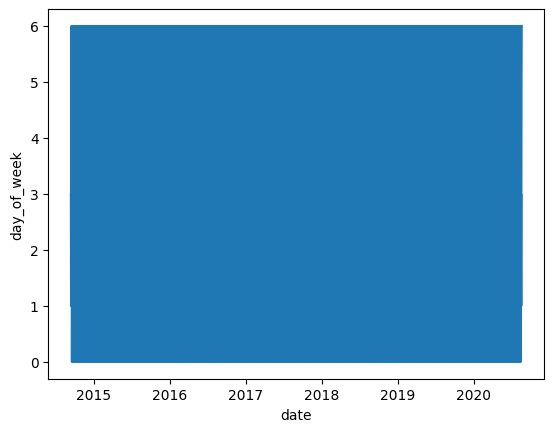

In [7]:
sns.lineplot(df["day_of_week"])

<Axes: xlabel='date', ylabel='page_loads'>

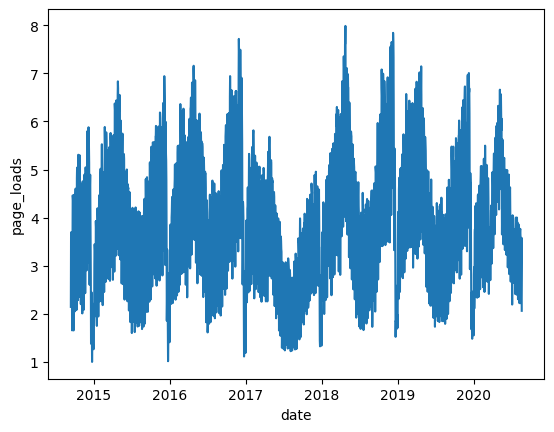

In [8]:
sns.lineplot(df["page_loads"])

<Axes: xlabel='date', ylabel='unique_visits'>

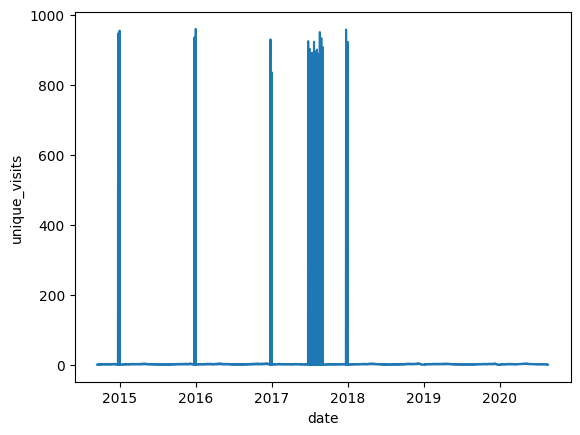

In [9]:
sns.lineplot(df["unique_visits"])

<Axes: xlabel='date', ylabel='first_time_visits'>

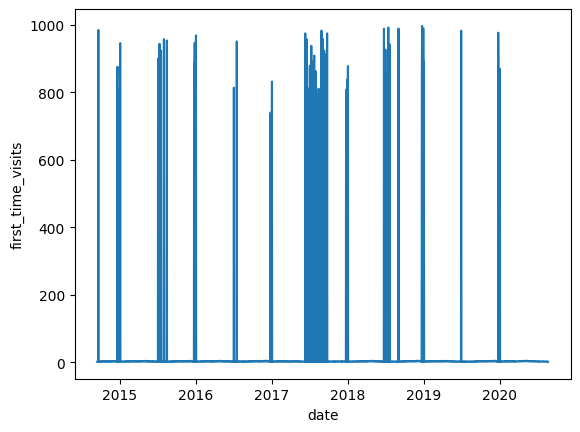

In [10]:
sns.lineplot(df["first_time_visits"])

<Axes: xlabel='date', ylabel='returning_visits'>

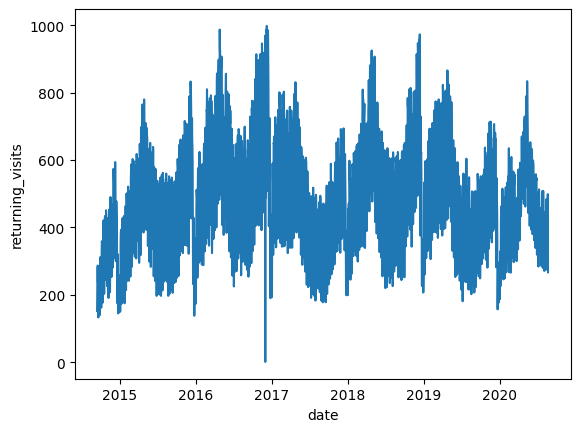

In [11]:
sns.lineplot(df["returning_visits"])

<Axes: >

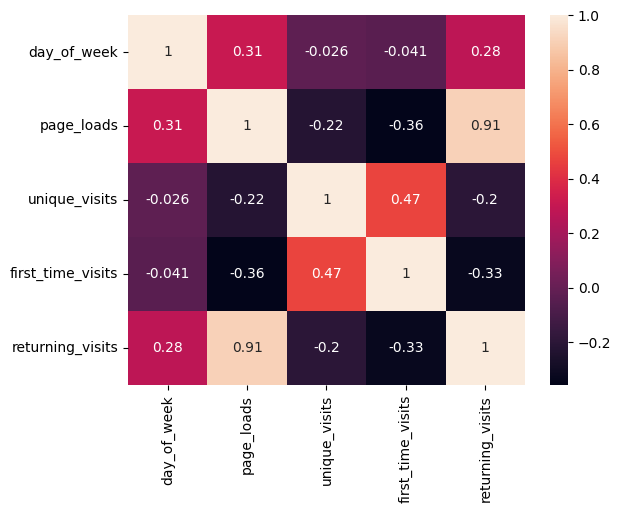

In [12]:
sns.heatmap(df.corr(), annot=True)

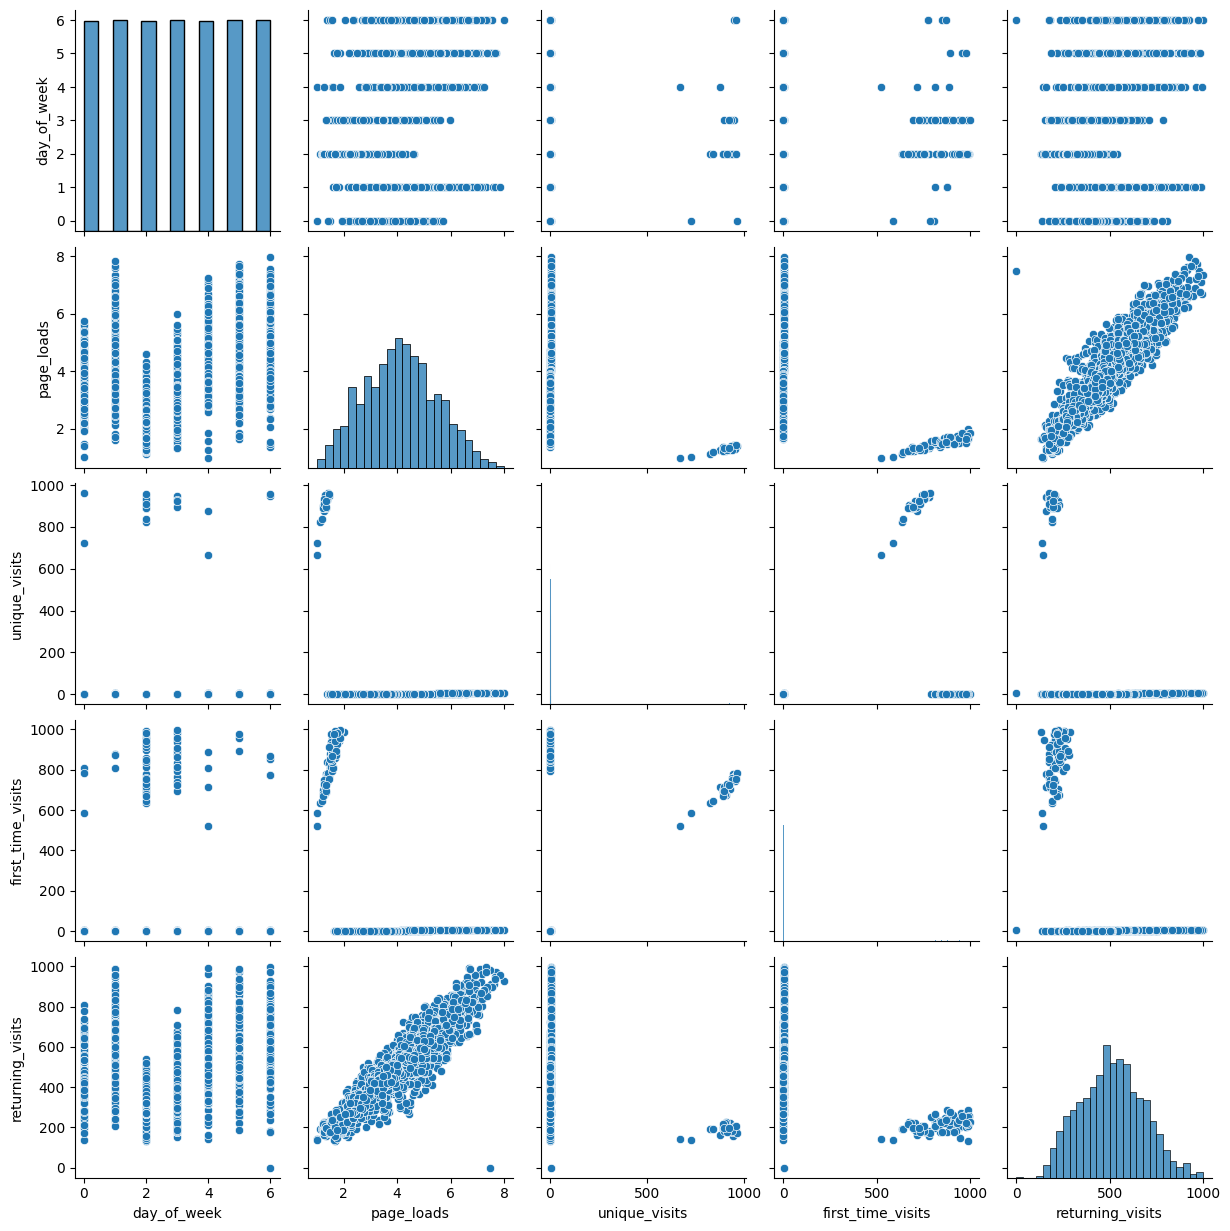

In [13]:
sns.pairplot(df)

# Feauture Extraction
Apply a lag of one, two, and three days to each chosen feature (except `day_of_week`), creating a set of features representing the statistics from the previous three days. To maintain dataset integrity, eliminate any resulting missing values at the beginning of the dataset.

Hint: Use `df['column_name'].shift(period)`. Check the documentation at https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shift.html.

In [14]:
df.columns

Index(['day_of_week', 'page_loads', 'unique_visits', 'first_time_visits',
       'returning_visits'],
      dtype='object')

In [15]:
features = ["day_of_week", "unique_visits", "first_time_visits", "returning_visits"]
target = "page_loads"

In [16]:
lags = range(3, 0, -1)
list(lags)

[3, 2, 1]

In [17]:
for lag in lags:
    for column in features + [target]:
        df[f"{column}_{lag}"] = df[column].shift(lag)
df.head()

,day_of_week,page_loads,unique_visits,first_time_visits,returning_visits,day_of_week_3,unique_visits_3,first_time_visits_3,returning_visits_3,page_loads_3,day_of_week_2,unique_visits_2,first_time_visits_2,returning_visits_2,page_loads_2,day_of_week_1,unique_visits_1,first_time_visits_1,returning_visits_1,page_loads_1
date,,,,,,,,,,,,,,,,,,,,
2014-09-14,3.0,2.146,1.582,1.430,152.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-15,1.0,3.621,2.528,2.297,231.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.582,1.430,152.0,2.146
2014-09-16,5.0,3.698,2.630,2.352,278.0,NaN,NaN,NaN,NaN,NaN,3.0,1.582,1.430,152.0,2.146,1.0,2.528,2.297,231.0,3.621
2014-09-17,6.0,3.667,2.614,2.327,287.0,3.0,1.582,1.430,152.0,2.146,1.0,2.528,2.297,231.0,3.621,5.0,2.630,2.352,278.0,3.698
2014-09-18,4.0,3.316,2.366,2.130,236.0,1.0,2.528,2.297,231.0,3.621,5.0,2.630,2.352,278.0,3.698,6.0,2.614,2.327,287.0,3.667


In [18]:
df.drop(columns=features, inplace=True)
df.dropna(axis=0, inplace=True)
df.head()

,page_loads,day_of_week_3,unique_visits_3,first_time_visits_3,returning_visits_3,page_loads_3,day_of_week_2,unique_visits_2,first_time_visits_2,returning_visits_2,page_loads_2,day_of_week_1,unique_visits_1,first_time_visits_1,returning_visits_1,page_loads_1
date,,,,,,,,,,,,,,,,
2014-09-17,3.667,3.0,1.582,1.430,152.0,2.146,1.0,2.528,2.297,231.0,3.621,5.0,2.630,2.352,278.0,3.698
2014-09-18,3.316,1.0,2.528,2.297,231.0,3.621,5.0,2.630,2.352,278.0,3.698,6.0,2.614,2.327,287.0,3.667
2014-09-19,2.815,5.0,2.630,2.352,278.0,3.698,6.0,2.614,2.327,287.0,3.667,4.0,2.366,2.130,236.0,3.316
2014-09-20,1.658,6.0,2.614,2.327,287.0,3.667,4.0,2.366,2.130,236.0,3.316,0.0,1.863,1.622,241.0,2.815
2014-09-21,2.288,4.0,2.366,2.130,236.0,3.316,0.0,1.863,1.622,241.0,2.815,2.0,1.118,985.000,133.0,1.658


## Dataset Splitting
Partition the dataset into training and testing sets with an 80:20 ratio.

**WARNING: DO NOT SHUFFLE THE DATASET.**



In [19]:
X, y = df.drop(columns=[target]), df[target]

In [20]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.20, shuffle=False)

## Ensemble Learning Methods

### Bagging

Create an instance of a Random Forest model and train it using the `fit` function.

In [21]:
forest = RandomForestRegressor()

In [22]:
forest.fit(train_X, train_y)

RandomForestRegressor()

Use the trained model to make predictions for the test set.

In [23]:
y_pred = forest.predict(test_X)

Assess the performance of the model by using different metrics provided by the `scikit-learn` library.

In [24]:
r2_score(test_y, y_pred)

0.8729871566123317

### Boosting

Create an instance of an XGBoost model and train it using the `fit` function.

In [25]:
xgb = XGBRegressor()

In [26]:
xgb.fit(train_X, train_y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Use the trained model to make predictions for the test set.

In [27]:
y_pred = xgb.predict(test_X)

Assess the performance of the model by using different metrics provided by the `scikit-learn` library.

In [28]:
r2_score(test_y, y_pred)

0.8802760108036887

# Laboratory Exercise - Bonus Task (+ 2 points)

As part of the bonus task in this laboratory assignment, your objective is to fine-tune the number of estimators (`n_estimators`) for the XGBoost model using a cross-validation with grid search and time series split. This involves systematically experimenting with various values for `n_estimators` and evaluating the model's performance using cross-validation. Upon determining the most suitable `n_estimators` value, evaluate the model's performance on a test set for final assessment.

Hints:
- For grid search use the `GridCVSearch` from the `scikit-learn` library. Check the documentation at https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html.
- For cross-validation use the `TimeSeriesSplit` from the `scikit-learn` library. Check the documentation at https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html.

## Dataset Splitting
Partition the dataset into training and testing sets with an 90:10 ratio.

**WARNING: DO NOT SHUFFLE THE DATASET.**

In [29]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.1, shuffle=False)

## Fine-tuning the XGBoost Hyperparameter
Experiment with various values for `n_estimators` and evaluate the model's performance using cross-validation.

In [30]:
time_series_split = TimeSeriesSplit(n_splits=5)
time_series_split.get_n_splits(X, y)

5

In [31]:
model = XGBRegressor()

In [32]:
model.get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [33]:
param_grid ={
    'n_estimators':[50, 100, 300],
    'max_depth': [10,15,20,25]
}

In [34]:
cv = GridSearchCV(estimator=model, param_grid=param_grid, cv=time_series_split)

In [35]:
cv.fit(X, y)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, imp...
                                    learning_rate=None, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'max_depth': [10, 15, 20, 25],
                         'n_estimators': [50, 100, 300]})

In [36]:
cv.best_score_

0.8961000824118683

In [37]:
model = cv.best_estimator_
model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [38]:
y_pred = model.predict(test_X)

## Final Assessment of the Model Performance
Upon determining the most suitable `n_estimators` value, evaluate the model's performance on a test set for final assessment.

In [39]:
r2_score(test_y, y_pred)

0.9998449651696099